In [1]:
import os
import re
import ROOT
import uproot
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
%matplotlib widget

Welcome to JupyROOT 6.28/00


In [2]:
def gaussian(x, mu, sig):
    return (1/(sig*np.sqrt(2.*np.pi)))*np.exp(-(x-mu)**2/(2*sig**2))

In [3]:
filename  = os.path.expandvars("$LUSTRE/Time/e-/tuning/fitted_timepdf.h5")

In [4]:
with tb.open_file(filename) as f:
    pbins    = f.root.bins.momentum.read()
    tresbins = f.root.bins.tres    .read()
    μbins    = f.root.bins.μ       .read()

    direct_timepdfs = f.root.direct_timepdfs.read()

    gaussian_fits   = 2*[None]
    polynomial_fits = 2*[None] 
    for i, param_type in enumerate(["means", "sigmas"]):
        gaussian_fits  [i] = getattr(f.root.gaussian_fits  , param_type).read()
        polynomial_fits[i] = getattr(f.root.polynomial_fits, param_type).read()

ps    = (pbins[1:] + pbins[:-1])/2.
tress = (tresbins[1:] + tresbins[:-1])/2.
μs    = (μbins[1:] + μbins[:-1])/2.

### Gaussian fits

Selecting p = 250.51024999999998 MeV and μ = 1.0


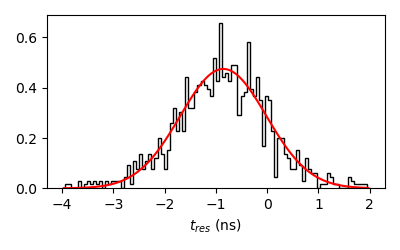

In [9]:
# select random momentum and μ bins

pindex = np.random.randint(len(ps)-1)
μindex = np.random.randint(len(μs)-1)

# p = 350
# pindex = np.digitize(p, pbins) - 1
# μ = np.log10(10.)
# μindex = np.digitize(μ, μbins) - 1

# print(f"Selecting p = {ps[pindex]} MeV and log10(μ) = {μs[μindex]}")
print(f"Selecting p = {ps[pindex]} MeV and μ = {μs[μindex]}")


plt.figure(figsize=(4, 2.5))

h = direct_timepdfs[pindex, :, μindex]
norm = np.sum(h*np.diff(tresbins))
plt.stairs(h/norm, tresbins, color="k")

mean  = gaussian_fits[0][pindex, μindex]
sigma = gaussian_fits[1][pindex, μindex]
plt.plot(tress, gaussian(tress, mean, sigma), color="r")

plt.xlabel(r"$t_{res}$ (ns)")
plt.tight_layout()

### Polynomial fits

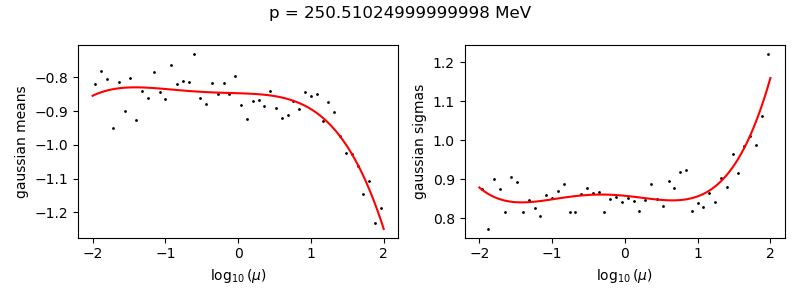

In [10]:
μsx = np.linspace(μbins[0], μbins[-1], 100)

plt.figure(figsize=(8, 3))
plt.suptitle(f"p = {ps[pindex]} MeV")

for i, param_type in enumerate(["means", "sigmas"]):

    plt.subplot(1, 2, i+1)
    plt.scatter(μs, gaussian_fits[i][pindex], s=1, color="k")
    poly_params = polynomial_fits[i][pindex]
    plt.plot(μsx, np.poly1d(np.flip(poly_params))(μsx), color="r")

    plt.xlabel(r"$\log_{10}(\mu)$")
    plt.ylabel(f"gaussian {param_type}")

plt.tight_layout()

### Parameters fits

In [56]:
partype = 1

with tb.open_file(filename) as f:
    if   partype == 0: parameters = getattr(f.root.parameter_fits,  "means").read()
    elif partype == 1: parameters = getattr(f.root.parameter_fits, "sigmas").read()

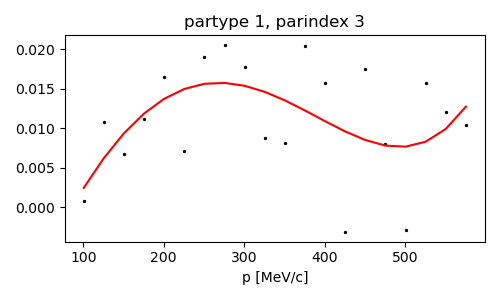

In [63]:
pari = np.random.randint(5)

plt.figure(figsize=[5, 3])
plt.title(f"partype {partype}, parindex {pari}")
plt.scatter(ps, polynomial_fits[partype][:, pari], s=2, color="k")

pol = np.poly1d(np.flip(parameters[pari]))
plt.plot(ps, pol(ps), color="r")
plt.xlabel("p [MeV/c]")
plt.tight_layout()

## Smoothness

In [7]:
μs = 1.

moms = np.linspace(ps[0], ps[-1], 100)
means  = np.zeros(len(moms))
sigmas = np.zeros(len(moms))
for mi, mom in enumerate(moms):
    i = np.digitize(mom, pbins)-1
    pars = polynomial_fits[0][i]
    pol = np.poly1d(np.flip(pars))
    means[mi] = pol(μs)
    pars = polynomial_fits[1][i]
    pol = np.poly1d(np.flip(pars))
    sigmas[mi] = pol(μs)

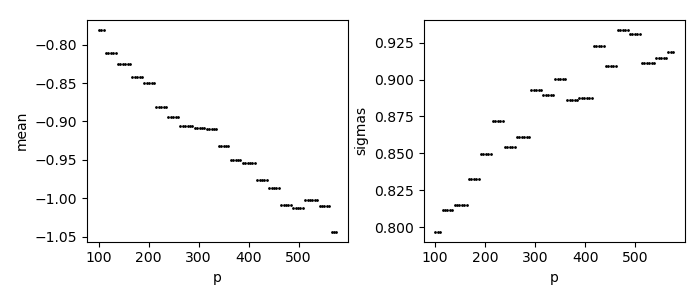

In [8]:
plt.figure(figsize=[7, 3])

plt.subplot(121)
plt.scatter(moms, means, color="k", label="gaussian means", s=1)
plt.xlabel("p")
plt.ylabel("mean")
plt.subplot(122)
plt.scatter(moms, sigmas, color="k", label="gaussian means", s=1)
plt.xlabel("p")
plt.ylabel("sigmas")

plt.tight_layout()